# Implementacja k-means

Zaimplementować swoją klasteryzację k-means i porównać ją z metodami wbudowanymi.
https://stanford.edu/~cpiech/cs221/handouts/kmeans.html

In [15]:
import numpy as np

In [16]:
import random
from scipy.cluster.vq import vq

def initial_centroids(X, k):
    initial = set()
    while len(initial) < k:
        initial.add(tuple(random.choice(X).tolist()))
    return np.array(list(initial))

def kmeans(X, k, max_iterations=np.inf):
    centroids = initial_centroids(X, k)
    finished = False
    iteration = 0
    codes_prev = np.zeros(X.shape[0])
    while not finished and iteration < max_iterations:
        # Assign each vector to cluster
        codes, dists = vq(X, centroids)
        # Find new centroids
        for i in range(k):
            centroids[i, :] = np.mean(X[codes == i], axis=0)
        
        if (codes == codes_prev).all():
            finished = True
            
        codes_prev = codes
        iteration += 1
    return codes.astype("int32"), centroids

In [17]:
from sklearn import datasets
iris = datasets.load_iris()
X = iris.data
Y = iris.target
Y_pred, centroids = kmeans(X, 3)
Y_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0,
       0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2])

## Dopasowanie rezultatu klasteryzacji do rzeczywistych klas decyzyjnych

TODO: jak to działa?

In [18]:
import scipy

def find_perm(clusters, Y_real, Y_pred):
    perm=[]
    for i in range(clusters):
        idx = Y_pred == i
        new_label = scipy.stats.mode(Y_real[idx])[0][0]
        perm.append(new_label)
    return np.array([perm[label] for label in Y_pred])

Y_pred = find_perm(3, Y, Y_pred)
Y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2,
       2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 1, 2, 1, 2, 2, 1, 1, 2, 2, 2, 2,
       2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 1])

## Obliczenie indeksu Jaccarda

TODO: co to indeks jacarda i jaka jest jego interpretacja?

In [19]:
from sklearn.metrics import jaccard_score

jaccard_score(Y, Y_pred, average=None)

array([1.        , 0.734375  , 0.67924528])

## Wizualizacja danych w przestrzeni 2D za pomocą metody PCA

In [20]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

In [132]:
# TODO convex hull
def plot_convex(data, y, ax):
    unique_labels = np.unique(y)
    for i in unique_labels:
        data_by_class = data[y == i, :]
        convex_hull = ConvexHull(data_by_class)
        for simplice in convex_hull.simplices:
            ax.plot(data_by_class[simplice, 0], data_by_class[simplice, 1], 'k')

Text(0.5, 1.0, 'Różnice')

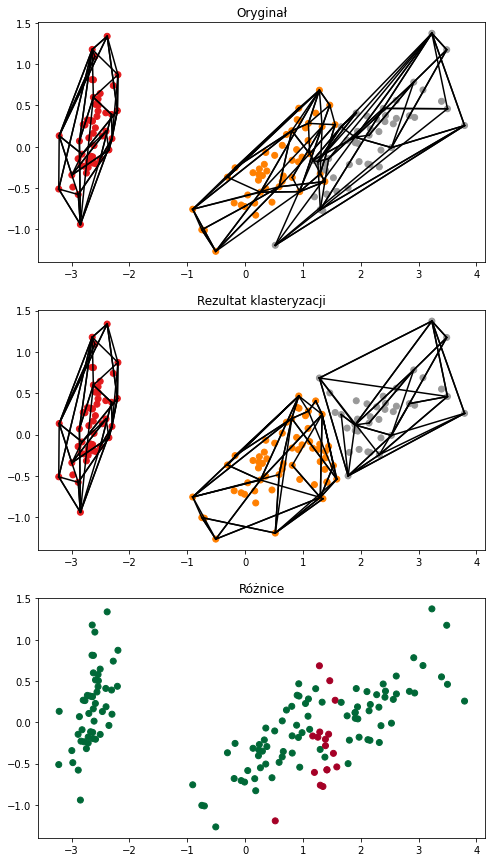

In [133]:
import matplotlib.pyplot as plt

from scipy.spatial import ConvexHull, convex_hull_plot_2d

fig, axes = plt.subplots(3, 1, figsize=(8, 15))
axes[0].scatter(X_reduced[:, 0], X_reduced[:, 1], c=Y, cmap='Set1')
plot_convex(X_reduced, Y, axes[0])
axes[1].scatter(X_reduced[:, 0], X_reduced[:, 1], c=Y_pred, cmap='Set1')
plot_convex(X_reduced, Y_pred, axes[1])
axes[2].scatter(X_reduced[:, 0], X_reduced[:, 1], c=Y==Y_pred, cmap='RdYlGn')
axes[0].set_title("Oryginał")
axes[1].set_title("Rezultat klasteryzacji")
axes[2].set_title("Różnice")

Text(0.5, 0.92, 'Różnice')

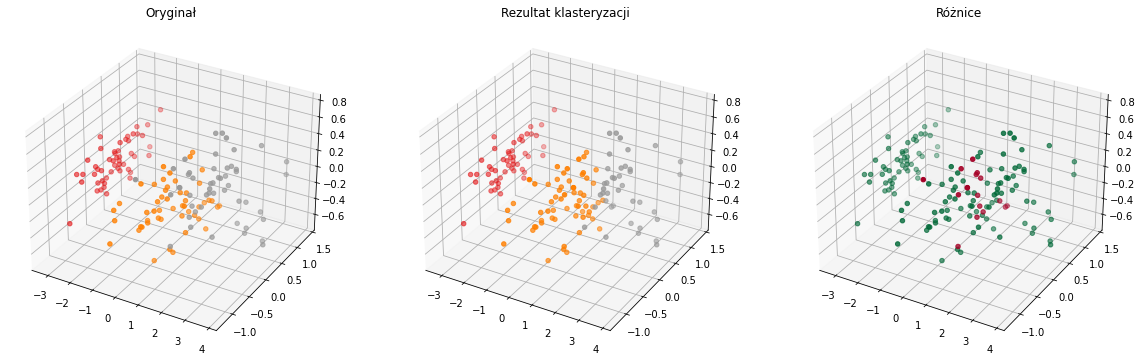

In [89]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(20, 20))
ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132, projection='3d')
ax3 = fig.add_subplot(133, projection='3d')

pca = PCA(n_components=3)
X_reduced = pca.fit_transform(X)

ax1.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=Y, cmap='Set1')
ax2.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=Y_pred, cmap='Set1')
ax3.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=Y==Y_pred, cmap='RdYlGn')
ax1.set_title("Oryginał")
ax2.set_title("Rezultat klasteryzacji")
ax3.set_title("Różnice")